## Fine Tune VGG16 Model
### VGG 16: Fine tuning a pre-trained Convolutional Neural Network on title position 
Given our goal to classify title location and count the number of faces in movie posters, we decided to fine-tune the VGG-16 Convolutional Neural Network by Simonyan & Zisserman, which is pre-trained to perform multi-class classification on a dataset of over 1 million input images assigned to over 1000 classes (Simonyan & Zisserman 2015,https://arxiv.org/pdf/1409.1556.pdf). Briefly, characteristics of the VGG network architecture include a large number of convolutional layers (depth of 16) and convolutional filters with a very small (3x3) receptive field. The depth of this network results in higher performance than previous models on object localization and image classification tasks. 
To preprocess our data and utilize this pre-tuned model, we re-sized posters to size 224x224 using zero-padding and normalized pixel values. To adapt this pre-trained model, we kept the first 15 layers constant (i.e. non-trainable), and modified the Dense layer to predict for 3 classes (top, middle, bottom title location). During training, we utilized Stochastic Gradient Descent with momentum 0.9 with a low learning rate to optimize weights. We used the same loss function and dense network architecture as above for both classification problems. 

Similar to the model we tuned from scratch, we then tuned the batch size and learning rate to obtain a reasonable good model.


In [55]:
#load pretrained model - VGG16
base_model =VGG16(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) # let's add a fully-connected layer 
x = Dropout(0.5)(x)
x = Dense(500, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(100, activation='relu')(x)
#x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)  # this is the model we will train 
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [58]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 50
# number of iterations over the complete training data
epochs = 10
# add early stopping
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [1]:
# fine-tune the model
nnet_mod = model.fit(img_matrix, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlyStopping],
                    validation_split=0.3)

### Model result
The result from the final model is shown below. The performance of this pre-trained model is much better than the model we built from scratch (has more than 60% accuracy). It is because VGG-16 model was trained on much larger data set, which is helpful for training the earlier layers for basic feature extraction. It would be easier to build on this model and recognize titles using the features. By fine tuning the last a few layers, we are able to make this model perform the title position classification.

From the loss plots, we can see that the loss value decreases until reaching a stable stage. We probably can use a slightly larger learning rate, since the current plot has a fast dropping stage. The value keeps dropping at about 200 epochs, so we have to force the model to quit and just show the beginning part of the plot. We will further adjust batch size and learning rate for this model. 

**Training loss:**

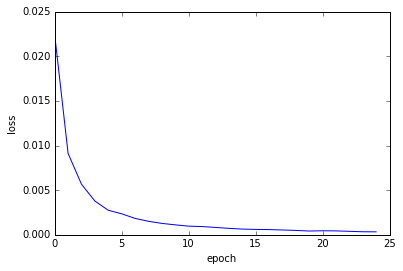

In [16]:
plt.plot(nnet_mod.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

**Validation loss **

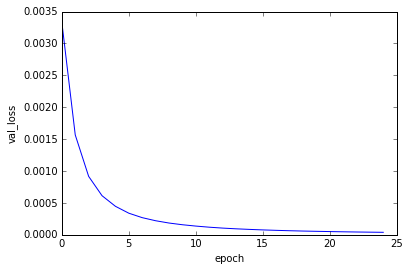

In [18]:
plt.plot(nnet_mod.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("val_loss")